In [ ]:
!makdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

/bin/bash: line 1: makdir: command not found
cp: cannot stat 'kaggle.json': No such file or directory


In [ ]:
!kaggle datasets download -d mohammadamireshraghi/blood-cell-cancer-all-4class

Dataset URL: https://www.kaggle.com/datasets/mohammadamireshraghi/blood-cell-cancer-all-4class
License(s): Attribution-NonCommercial 4.0 International (CC BY-NC 4.0)
100% 1.68G/1.68G [00:23<00:00, 110MB/s] 
100% 1.68G/1.68G [00:23<00:00, 78.1MB/s]


In [ ]:
import zipfile
zip_ref = zipfile.ZipFile('/content/blood-cell-cancer-all-4class.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close

<bound method ZipFile.close of <zipfile.ZipFile filename='/content/blood-cell-cancer-all-4class.zip' mode='r'>>

In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from keras import Sequential
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense
import os
import shutil
import random
from keras.layers import BatchNormalization, Dropout

In [2]:
# Define the source directory and the destination directories
source_dir = 'Blood cell Cancer [ALL]'
train_dir = 'train'
test_dir = 'test'

# Create the destination directories if they don't exist
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Iterate through the subdirectories (classes) in the source directory
for class_name in ['Benign','[Malignant] Pre-B', '[Malignant] Pro-B', '[Malignant] early Pre-B']:
    class_dir = os.path.join(source_dir, class_name)

    # Get a list of all image files in the class directory
    image_files = os.listdir(class_dir)

    # Shuffle the image files randomly
    random.shuffle(image_files)

    # Calculate the split index for train and test (e.g., 80% train, 20% test)
    split_index = int(0.8 * len(image_files))

    # Copy images to the train and test directories
    for i, image_file in enumerate(image_files):
        source_path = os.path.join(class_dir, image_file)
        if i < split_index:
            destination_path = os.path.join(train_dir, class_name, image_file)
        else:
            destination_path = os.path.join(test_dir, class_name, image_file)

        # Create the destination directory if it doesn't exist
        os.makedirs(os.path.dirname(destination_path), exist_ok=True)

        # Copy the image file
        shutil.copy(source_path, destination_path)

print("Train and test data folders created successfully.")

Train and test data folders created successfully.


In [3]:


# Define a preprocessing function to ensure correct number of channels and normalization
def process(image, label):
    image = tf.cast(image / 255.0, tf.float32)
    return image, label

# Function to filter out corrupted images
def is_valid_image(file_path):
    try:
        img = tf.io.read_file(file_path)
        img = tf.image.decode_image(img, channels=3)
        return True
    except:
        return False

# Remove corrupted images
def clean_dataset(dataset_dir):
    for class_name in ['Benign','[Malignant] Pre-B', '[Malignant] Pro-B', '[Malignant] early Pre-B']:
        class_dir = os.path.join(dataset_dir, class_name)
        image_files = os.listdir(class_dir)
        for image_file in image_files:
            file_path = os.path.join(class_dir, image_file)
            if not is_valid_image(file_path):
                os.remove(file_path)
                print(f"Removed corrupted image: {file_path}")

clean_dataset(train_dir)
clean_dataset(test_dir)

In [4]:
#load the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(224, 224),
    batch_size=32
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(224, 224),
    batch_size=32
)

Found 2592 files belonging to 4 classes.
Using 2074 files for training.
Found 2592 files belonging to 4 classes.
Using 518 files for validation.


In [5]:
#Use the VGG16 model
base_model = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 25s 0us/step


In [6]:
#freeze the base model
base_model.trainable = False


In [7]:
model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(224, 224, 3)),  # Explicitly define input shape
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(4, activation='softmax')
])


C:\Users\khani\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


In [8]:
#model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4)              │         2,052 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,716,740 (56.14 MB)

 Trainable params: 2,052 (8.02 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [9]:
#compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [10]:
#fit the model
history = model.fit(train_ds, validation_data=val_ds, epochs=15)


Epoch 1/15


65/65 ━━━━━━━━━━━━━━━━━━━━ 607s 9s/step - accuracy: 0.2683 - loss: 5.3015 - val_accuracy: 0.6853 - val_loss: 0.8394
Epoch 2/15
65/65 ━━━━━━━━━━━━━━━━━━━━ 508s 8s/step - accuracy: 0.7427 - loss: 0.6856 - val_accuracy: 0.8842 - val_loss: 0.3057
Epoch 3/15
65/65 ━━━━━━━━━━━━━━━━━━━━ 528s 8s/step - accuracy: 0.8901 - loss: 0.3044 - val_accuracy: 0.9247 - val_loss: 0.1939
Epoch 4/15
65/65 ━━━━━━━━━━━━━━━━━━━━ 472s 7s/step - accuracy: 0.9301 - loss: 0.2047 - val_accuracy: 0.9517 - val_loss: 0.1462
Epoch 5/15
65/65 ━━━━━━━━━━━━━━━━━━━━ 487s 8s/step - accuracy: 0.9555 - loss: 0.1466 - val_accuracy: 0.9633 - val_loss: 0.1228
Epoch 6/15
65/65 ━━━━━━━━━━━━━━━━━━━━ 501s 8s/step - accuracy: 0.9609 - loss: 0.1207 - val_accuracy: 0.9672 - val_loss: 0.1074
Epoch 7/15
65/65 ━━━━━━━━━━━━━━━━━━━━ 510s 8s/step - accuracy: 0.9644 - loss: 0.1062 - val_accuracy: 0.9672 - val_loss: 0.0937
Epoch 8/15
65/65 ━━━━━━━━━━━━━━━━━━━━ 473s 7s/step - accuracy: 0.9656 - loss: 0.0986 - val_accuracy: 0.9710 - val_loss: 0.

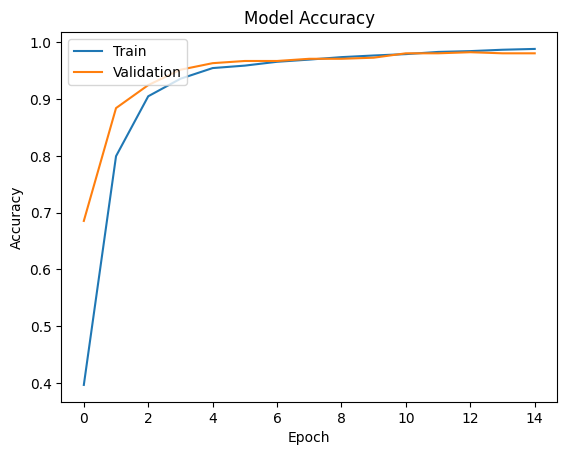

In [11]:
#plot the accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

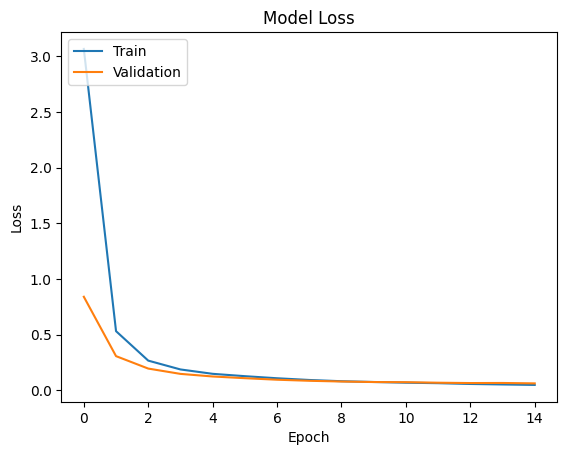

In [12]:
#plot the loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [13]:
#save the model
model.save('model.h5')

In [14]:
#test the model
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    image_size=(224, 224),
    batch_size=32
)

Found 650 files belonging to 4 classes.


In [33]:
#check the model on single image to predict the output
import numpy as np
from keras.preprocessing import image
test_image = image.load_img('Benign_image.jpg', target_size = (224, 224))
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis = 0)
result = model.predict(test_image)
print(result)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step
[[9.9764484e-01 2.5072752e-04 1.6013668e-03 5.0307857e-04]]


In [34]:
# to print the class name
import numpy as np
from keras.preprocessing import image
test_image = image.load_img('Benign_image.jpg', target_size = (224, 224))
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis = 0)
result = model.predict(test_image)
print(np.argmax(result, axis=1))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step
[0]


In [35]:
#know make a code togive an image as input and the output will show the class name of that image
if np.argmax(result, axis=1) == 0:
  print('Benign')
elif np.argmax(result, axis=1) == 1:
  print('[Malignant] Pre-B')
elif np.argmax(result, axis=1) == 2:
  print('[Malignant] Pro-B')
elif np.argmax(result, axis=1) == 3:
  print('[Malignant] early Pre-B')
else:
  print('Not Identify the Image Class')


Benign


In [36]:
#Confusion Matrix: This provides a summary of the prediction results on a classification problem and helps in understanding the performance of the model.
from sklearn.metrics import confusion_matrix
import numpy as np

y_pred = model.predict(test_ds)
y_pred_classes = np.argmax(y_pred, axis=1)

# Extract true labels from the dataset
y_true = []
for images, labels in test_ds:
    y_true.extend(labels.numpy())

confusion_mtx = confusion_matrix(y_true, y_pred_classes)
print(confusion_mtx)

21/21 ━━━━━━━━━━━━━━━━━━━━ 111s 5s/step
[[17 31 20 35]
 [39 49 47 56]
 [15 51 44 50]
 [31 54 52 59]]


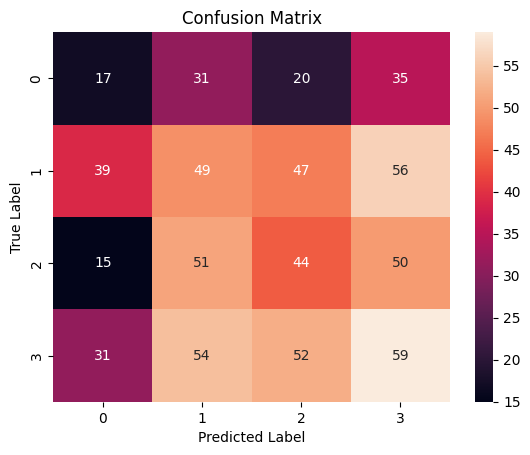

Text(70.72222222222221, 0.5, 'True Label')

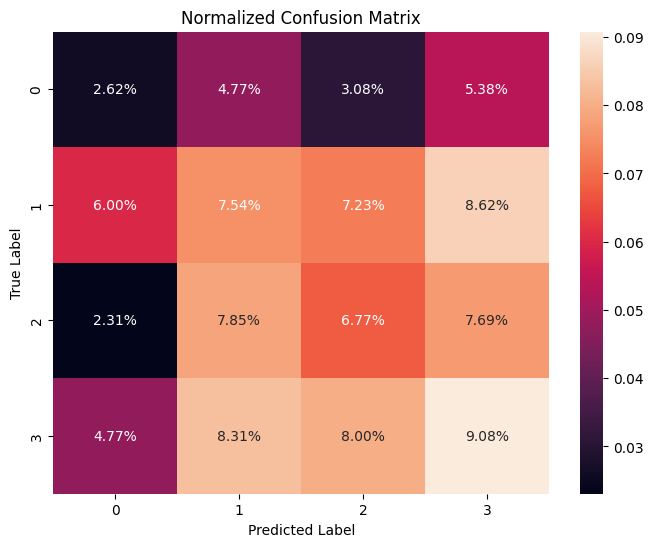

In [37]:
#plote the confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt
sns.heatmap(confusion_mtx, annot=True, fmt="d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()
#plote the confusion matrix normalizzed
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mtx / np.sum(confusion_mtx), annot=True, fmt=".2%")
plt.title("Normalized Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


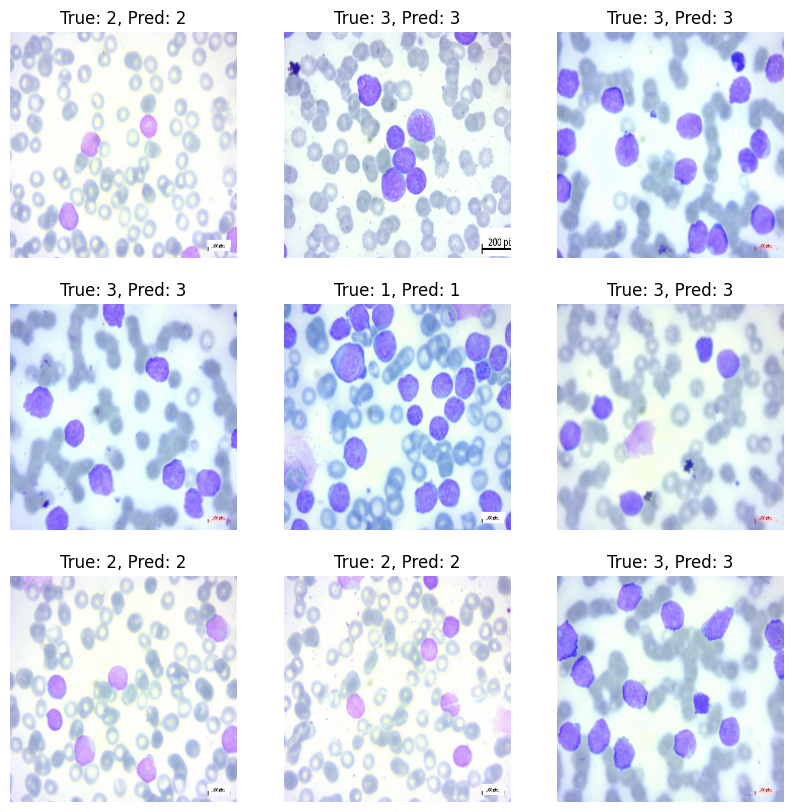

In [38]:
#Sample Predictions: Visualize a few sample images with their predicted and true labels.
sample_images, sample_labels = next(iter(test_ds))
predicted_labels = np.argmax(model.predict(sample_images), axis=1)

plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(sample_images[i].numpy().astype("uint8"))
    plt.title(f"True: {sample_labels[i]}, Pred: {predicted_labels[i]}")
    plt.axis("off")
plt.show()

True Label: [Malignant] Pro-B, Predicted Label: [Malignant] Pro-B


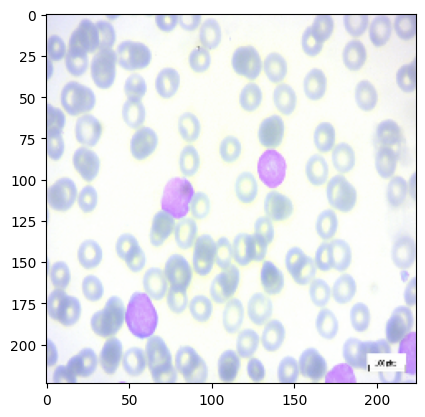


True Label: [Malignant] early Pre-B, Predicted Label: [Malignant] early Pre-B


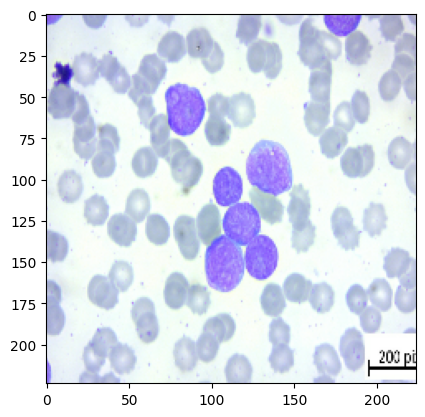


True Label: [Malignant] early Pre-B, Predicted Label: [Malignant] early Pre-B


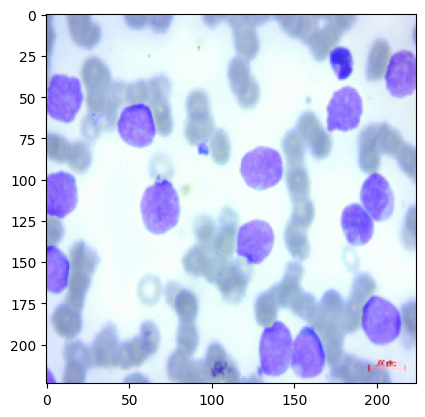


True Label: [Malignant] early Pre-B, Predicted Label: [Malignant] early Pre-B


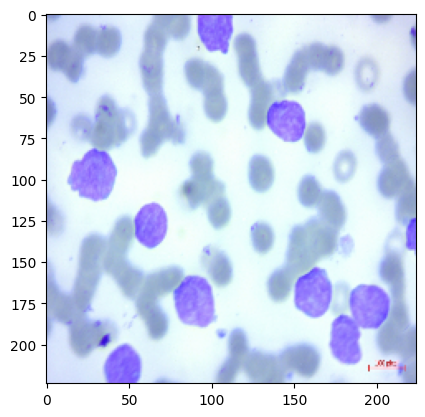


True Label: [Malignant] Pre-B, Predicted Label: [Malignant] Pre-B


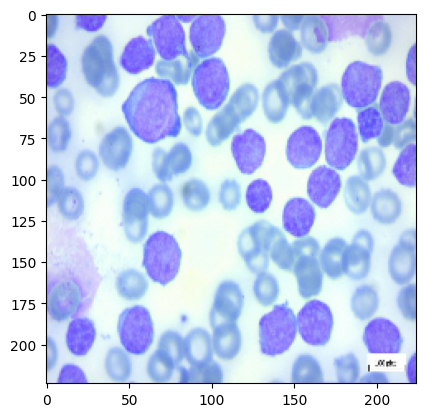


True Label: [Malignant] early Pre-B, Predicted Label: [Malignant] early Pre-B


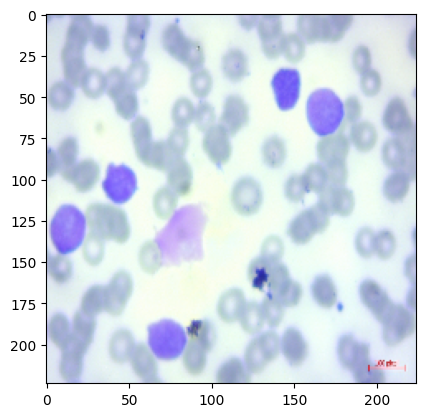


True Label: [Malignant] Pro-B, Predicted Label: [Malignant] Pro-B


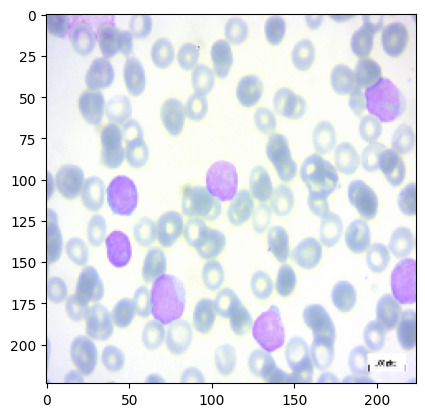


True Label: [Malignant] Pro-B, Predicted Label: [Malignant] Pro-B


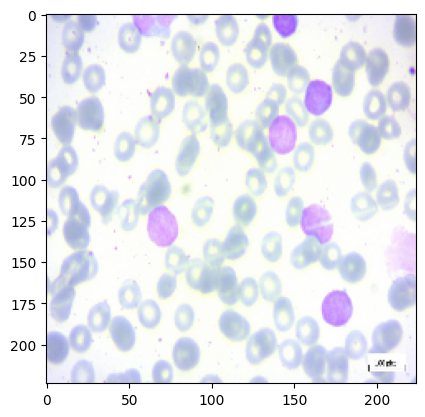


True Label: [Malignant] early Pre-B, Predicted Label: [Malignant] early Pre-B


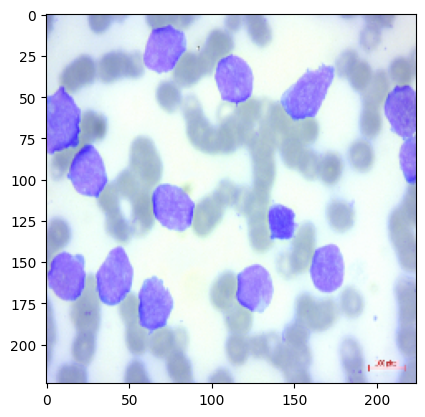

In [39]:
#Know label name the above ploted images with his names
labels = ['Benign','[Malignant] Pre-B', '[Malignant] Pro-B', '[Malignant] early Pre-B']
for i in range(9):
    print(f"True Label: {labels[sample_labels[i]]}, Predicted Label: {labels[predicted_labels[i]]}")
    #plot the images
    plt.imshow(sample_images[i].numpy().astype("uint8"))
    plt.show()
    print()



In [4]:
#import the model\
    
import tensorflow as tf 
import tensorflow.keras 
from tensorflow.keras.models import load_model

# Load the model
loaded_model = tf.keras.models.load_model('saved_model/my_model')

# Verify the model summary
loaded_model.summary()

ValueError: Layer "dense" expects 1 input(s), but it received 2 input tensors. Inputs received: [<KerasTensor shape=(None, 7, 7, 512), dtype=float32, sparse=False, name=keras_tensor_84>, <KerasTensor shape=(None, 7, 7, 512), dtype=float32, sparse=False, name=keras_tensor_85>]

In [1]:
#check the model on single image to predict the output
import numpy as np
from keras.preprocessing import image
test_image = image.load_img('Ben.jpg', target_size = (224, 224))
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis = 0)
result = model.predict(test_image)
print(result)

NameError: name 'model' is not defined